In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import Parameter
import torch.optim as optim
import torch.nn.functional as F

import pickle
import numpy as np
import math # to check nan
from tqdm import tqdm
from sklearn import metrics

In [2]:
HYP={
    'node_num':128,
    'miss_percent':0.1,
    'seed':2052,
    'batch_size':1024,
    'lr_net':0.001,
    'lr_dyn':0.001
}

In [3]:
del_num = int(HYP['node_num']*HYP['miss_percent'])

In [4]:
torch.manual_seed(HYP['seed'])

## dynamics learner

In [5]:
## here is a dynamics learner, and ites optimizer
class IO_B(nn.Module):
    """docstring for IO_B"""
    def __init__(self,dim,hid):
        super(IO_B, self).__init__()
        self.dim = dim
        self.hid = hid
        self.n2e = nn.Linear(2*dim,hid)
        self.e2e = nn.Linear(hid,hid)
        self.e2n = nn.Linear(hid,hid)
        self.n2n = nn.Linear(hid,hid)
        self.output = nn.Linear(dim+hid,dim)
    def forward(self, x, adj_col, i):
        # x : features of all nodes at time t,[b*n*d]
        # adj_col : i th column of adj mat,[n]
        # i : just i
        starter = x # [batch,node,dim]
        ender = x[:,i,:] # [batch,dim]
        ender = ender.unsqueeze(1) #[batch,1,dim]

        ender = ender.expand(starter.size(0),starter.size(1),starter.size(2)) #[batch,node,dim]
        x = torch.cat((starter,ender),2) #[batch,node,2dim]
        x = F.relu(self.n2e(x))#[batch,node,hid]

        x = F.relu(self.e2e(x))#[batch,node,hid]
        adj_col = adj_col.unsqueeze(1)#[node,1]
        adj_col = adj_col.unsqueeze(0).repeat(x.shape[0],1,x.shape[2]) #[batch,node,hid]
        
        x = x * adj_col#[batch,node,hid]

        x = torch.sum(x,1)#[batch,hid]
        x = F.relu(self.e2n(x))#[batch,hid]
        x = F.relu(self.n2n(x))#[batch,hid]

        x = torch.cat((starter[:,i,:],x),dim=-1)#[batch,hid+dim]
        x = self.output(x)#[batch,dim]

        # skip connection
        # x = starter[:,i,:]+x # dont want in CML
        return x

In [6]:
dyn = IO_B(1,16)
op_dyn = optim.Adam(dyn.parameters(), lr=HYP['lr_dyn'])

## kron network generator

In [7]:
# kronecker product for 2 matrix
def kronecker(A,B):
    return torch.einsum("ab,cd->acbd", A, B).view(A.size(0)*B.size(0),  A.size(1)*B.size(1))

## network generator, and ites optimizer
class Gumbel_union_kron(nn.Module):
    def __init__(self,sz,k):
        super(Gumbel_union_kron,self).__init__()
        self.p = Parameter(torch.Tensor(sz,sz).uniform_(0,0.5))
#         self.p = Parameter(torch.tensor([[0.92,0.4],[0.5,0.6]]))
        self.k = k
    
    # generate adj from original kernel
    def generate_adj(self):
        p0 = torch.relu(self.p-0.001)+0.001 - torch.relu(self.p-0.999)
        adj = torch.relu(self.p-0.001)+0.001 - torch.relu(self.p-0.999)
        for i in range(self.k-1):
            adj = kronecker(adj,p0)
        return adj
    
    def sample_all(self):
        p1 = self.generate_adj() # prob to get 1
        p0 = 1-p1 # prob to get 0
        logits = torch.cat([p0.unsqueeze(2),p1.unsqueeze(2)],dim=2)#[node,node,2]
        # log it to suit for gumbel softmax
        logits = torch.log(logits)#[node,node,2]
        # gumbel softmax
        sampled_adj = torch.nn.functional.gumbel_softmax(logits,hard=False,tau=1)[:,:,1]
        return sampled_adj
    # generate p0 to init former gumbel generator
    def generate_p0_for_init(self):
        p1 = self.generate_adj() # prob to get 1
        p0 = 1-p1 # prob to get 0
        logits = torch.cat([p0.unsqueeze(2),p1.unsqueeze(2)],dim=2)#[node,node,2]
        # log it to suit for gumbel softmax
        logits = torch.log(logits)#[node,node,2]
        return logits

In [8]:
g = Gumbel_union_kron(2,7)

In [9]:
adj = g.generate_adj()

In [10]:
adj[0,-del_num:]

tensor([0.0018, 0.0016, 0.0016, 0.0015, 0.0018, 0.0016, 0.0016, 0.0015, 0.0016,
        0.0015, 0.0015, 0.0013], grad_fn=<SliceBackward>)

## Normal Gumbel Generator

In [11]:
# normal network generator
class Gumbel_Generator(nn.Module):
    def __init__(self,sz):
        super(Gumbel_Generator,self).__init__()
        self.p = Parameter(torch.randn(sz,sz,2))
    def generate_adj(self):
        p0 = torch.nn.functional.softmax(self.p,dim=2)[:,:,1]
        symp0 = torch.triu(p0,diagonal=0)+torch.triu(p0,diagonal=1).transpose(0,1) # make it symmetric
        return symp0
    def sample_all(self):
        sampled_adj = torch.nn.functional.gumbel_softmax(self.p,hard=False,tau=1)[:,:,1]
        sym_adj = torch.triu(sampled_adj,diagonal=0)+torch.triu(sampled_adj,diagonal=1).transpose(0,1)# make it symmetric
        return sym_adj

In [12]:
generator = Gumbel_union_kron(2,7)
# generator = Gumbel_Generator(128)
op_net = optim.Adam(generator.parameters(), lr=HYP['lr_net'])

In [13]:
generator.generate_adj().shape

torch.Size([128, 128])

## load data

In [14]:
def load_cml_ggn(data_path,batch_size = 128,node=10,seed=2050):

    with open(data_path, 'rb') as f:
        object_matrix, train_data, val_data, test_data = pickle.load(f) # (samples, nodes, timesteps, 1)
    
    print('\nMatrix dimension: %s \nTrain data size: %s \nVal data size: %s \nTest data size: %s'
          % (object_matrix.shape, train_data.shape, val_data.shape, test_data.shape))    

    train_loader = DataLoader(train_data[:], batch_size=batch_size, shuffle=False)#
    val_loader = DataLoader(val_data[:], batch_size=batch_size, shuffle=False) # 记得改回来
    test_loader = DataLoader(test_data[:], batch_size=batch_size, shuffle=False) # 记得改回来
    return train_loader,val_loader,test_loader,object_matrix

In [15]:
# load data
data_path = './data/2000cmlkron-ws128-10000-00.pickle'
# data_path = './data/2000cmlkron-10-100-10000-00.pickle'

# a = torch.load(data_path,map_location=torch.device('cpu'))
train_loader, val_loader, test_loader, object_matrix = load_cml_ggn(data_path,batch_size=HYP['batch_size'],node=HYP['node_num'])


Matrix dimension: torch.Size([128, 128]) 
Train data size: torch.Size([10000, 128, 2, 1]) 
Val data size: torch.Size([2000, 128, 2, 1]) 
Test data size: torch.Size([2000, 128, 2, 1])


In [16]:
observed_adj = object_matrix[:-del_num,:-del_num]

In [17]:
un_edges = object_matrix[-del_num:,-del_num:].sum()

## unknown x generator

In [18]:
## generate initial state for unobserved nodes
class Unknown_X_Generator(nn.Module):
    def __init__(self,batch_num,batch_sz,unobserved_node):
        super(Unknown_X_Generator,self).__init__()
        self.para = Parameter(torch.Tensor(batch_num,batch_sz,unobserved_node).uniform_(0,1))
    
    # get x
    def get_x(self,batch_idx):
        return self.para[batch_idx,:,:].unsqueeze(2) #[batchsz,unobserved_node,1]

In [19]:
train_uxg = Unknown_X_Generator(len(train_loader),HYP['batch_size'],del_num)
op_uxg = optim.Adam(train_uxg.parameters(), lr=HYP['lr_net'])

## loss function

In [20]:
loss_f = nn.MSELoss()

## train by observed part

In [21]:
# train by observed structure
def train_stru():
    op_net.zero_grad()
#     print('before op')
#     print(generator.p)
    hypo_adj = generator.generate_adj()
    o_part = hypo_adj[:-del_num,:-del_num]

    loss = loss_f(o_part,observed_adj)
#     print('loss')
#     print(loss)
    loss.backward()
#     print('grad')
#     print(generator.p.grad)
    op_net.step()
    
#     print('after op')
#     print(generator.p)
#     d()

## get auc of unknown part

In [22]:
def auc_unknown(p0,object_matrix,del_num):
    yscore = []
    y = []
    for i in range(p0.shape[0]):
        if i < p0.shape[0]-del_num:
            yscore.extend(p0[i,-del_num:])
            y.extend(object_matrix[i,-del_num:])
        else:
            yscore.extend(p0[i])
            y.extend(object_matrix[i])
    yscore = np.array(yscore)
    y_true = np.array(y)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, yscore,drop_intermediate=False)
    area = metrics.auc(fpr, tpr)
    return area

## train by structure

In [23]:
areas = []
for i in tqdm(range(500)):
    train_stru()
#     print(generator.p)
    p0 = generator.generate_adj().detach().numpy()
    area = auc_unknown(p0,object_matrix,del_num)
    areas.append(area)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 49.15it/s]


In [24]:
import matplotlib.pyplot as plt

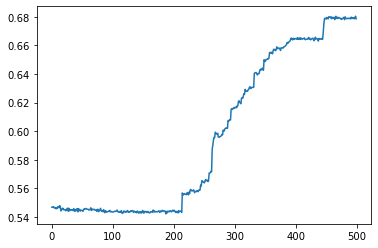

In [25]:
plt.plot(areas)
plt.show()

Parameter containing:
tensor([[0.9274, 0.5443],
        [0.5449, 0.6819]], requires_grad=True)

In [28]:
# normal network generator
class Gumbel_Generator(nn.Module):
    def __init__(self,sz,init_p0):
        super(Gumbel_Generator,self).__init__()
#         self.p = Parameter(torch.randn(sz,sz,2))
        self.p = Parameter(init_p0)
    def generate_adj(self):
        p0 = torch.nn.functional.softmax(self.p,dim=2)[:,:,1]
        symp0 = torch.triu(p0,diagonal=0)+torch.triu(p0,diagonal=1).transpose(0,1) # make it symmetric
        return symp0
    def sample_all(self):
        sampled_adj = torch.nn.functional.gumbel_softmax(self.p,hard=False,tau=1)[:,:,1]
        sym_adj = torch.triu(sampled_adj,diagonal=0)+torch.triu(sampled_adj,diagonal=1).transpose(0,1)# make it symmetric
        return sym_adj

In [31]:
init_p0 = generator.generate_p0_for_init().detach()

In [33]:
g1 = Gumbel_Generator(2,init_p0)

In [ ]:
def train_dyn_gen():
    losses = []
    for b_idx,data in enumerate(train_loader):
        # data:[batch,node,2,1]
        x = data[:,:-del_num,0,:] # [batchsz,observed_node,1]
        y = data[:,:-del_num,1,:] # same size
        
        # pred state for each node which can be observed
        for j in range(HYP['node_num']-del_num):
            print(generator.p[10,0,:])
            op_net.zero_grad()
            op_uxg.zero_grad()
            op_dyn.zero_grad()
            
            
            thisbatchsz = x.shape[0]
            x_un_paed = train_uxg.get_x(b_idx)[:thisbatchsz] #[batchsz,unobserved_node,1]
            x_hypo = torch.cat([x,x_un_paed],dim=1) #[batchsz,node,1]
            
            hypo_adj = generator.sample_all()
            
            # replace the observed part
            t0 = torch.ones(hypo_adj.shape)
            t0[:-del_num,:-del_num] = 0
            t1 = torch.zeros(hypo_adj.shape)
            t1[:-del_num,:-del_num] = observed_adj
            hypo_adj = hypo_adj*t0+t1
            
            adj_col = hypo_adj[:,j]
            
            yhat = dyn(x_hypo,adj_col,j)
            loss = loss_f(yhat,y[:,j,:])
            loss.backward()
            
            
            print(generator.p.grad[10,0,:])
            
            
            op_net.step()
            op_dyn.step()
            op_uxg.step()
            print(generator.p[10,0,:])
            d()
            losses.append(loss.item())
    return np.mean(losses)

In [ ]:
areas = []
losses = []
for i in tqdm(range(10)):
    loss = train_dyn_gen()
    losses.append(loss)
    # check auc
    p0 = generator.generate_adj().detach().numpy()
    area = auc_unknown(p0,object_matrix,del_num)
    areas.append(area)

In [ ]:
plt.plot(areas)
plt.show()